# Deep Learning Featured Model Training

This is the notebook used for training the CNN models in the Deep learning section of the report.
Notes: 
* Multiple combinations of data and hyper parameters were evaluated with a classic CNN architecture
* Trained models are then saved as .keras files with descriptive naming conventions indicating the settings used for training. 
* This notebook as saved can recreate the training of the "Chosen Model" for both MFCC and Log Melspectrogram scenarios.  For recreating other scenarios, you may need to modify some settings. 
* The separate deep_learning_model_evaluation notbook has comparative evaluations across multiple modeling scenarios for each of the two feature types. In this notebook, it demonstrates the righ way to load and process data to properly evaluate each scenario.  It also shows the file names for each scenario. 

In [1]:
import sys
sys.path.insert(0, '../../')
from library.notebook_api.deep_learning_training_data import get_feature_vector_data,get_augmented_x_y
from library.notebook_api.deep_learning_models import  get_2d_cnn
from library.notebook_api.model_evaluation import plot_training_history, ModelEvaluation
from configuration import SAVED_MODEL_PATH
from tensorflow import keras
import numpy as np

2024-12-09 10:47:28.192834: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Scenario 1: Using MFCC 13X500 , or 13X100 feature vector
This section utilizes the Mel Frequency Cepstrum Coefficient feature, downsampled to 22500 khz


In [9]:
X_train, X_test, y_train, y_test,label_encoder =get_feature_vector_data(vector_type = 'mfcc',
                                                        version_string = '006',
                                                        #vector_length = 500, #used for all scenarios besides segment augmentation
                                                        vector_length = 1000,  #used for segment augmentation
                                                        apply_normalization = True, #normalization used across scenarios 
                                                        #apply_resampling=True #uses RandomOverSampling
                                                        )

Loading mfcc vectors
features shape distribution
1099    20865
1         221
293         2
173         2
862         2
392         1
467         1
201         1
946         1
622         1
Name: count, dtype: int64
total records:  21164
normalized length:  20865
Row Count after label based filter:  21164
Final Row count after label and feature filter:  20865
Unique label count:  6
label data count  20865
Truncate features to consistent length and reshape
Generate train_test_split for test size  0.2
applying normalization


In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(TensorShape([16692, 1000, 13, 1]),
 TensorShape([4173, 1000, 13, 1]),
 (16692, 6),
 (4173, 6))

This section is to over-write the data with augmented data, only used for segment augmentation scenarios.   Augmentation produces multiple overlappiping segments from each audio file, and applies some weight bias to generate more segments for under represented classes.  this scenario augments the train and test sets separately to avoid lekage and to allow for consistent shapes of vectors across train test


In [11]:



X_train, y_train  = get_augmented_x_y(X_train, 
                                    y_train, 
                                    num_segments=5, 
                                    overlap_factor=.3,
                                    row_resample_weight_100_perc_thresh=.9,
                                    discount_weight_factor=.25
                                    )

X_test, y_test  = get_augmented_x_y(X_test, 
                                    y_test, 
                                    num_segments=5, 
                                    overlap_factor=.3,
                                    row_resample_weight_100_perc_thresh=.9,
                                    discount_weight_factor=.25
                                    )

creating augmented data with segment boundaries [[0, 260], [200, 460], [400, 660], [600, 860], [739, 999]]
weights to resample labels are [0.93703571 0.9859214  0.68487898 0.82680326 0.96794872 0.59741193]
creating augmented data with segment boundaries [[0, 260], [200, 460], [400, 660], [600, 860], [739, 999]]
weights to resample labels are [0.9369758  0.98586149 0.68511862 0.82674335 0.96788881 0.59741193]


In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21530, 260, 13, 1), (5457, 260, 13, 1), (21530, 6), (5457, 6))

In [15]:
np.unique(np.argmax(y_train,axis=1),return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([5255, 1175, 4540, 2927, 2675, 4958]))

In [16]:
selected_hp = {'learning_rate':  0.0001}
#selected_hp = {'learning_rate':  0.001} #manually experiment with different learning rates

type(selected_hp)
model_1 = get_2d_cnn(selected_hp) #get model 


In [17]:
history = model_1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    
    #batch_size=32, #manually experimented with different values
    #batch_size=64,
    batch_size = 128,
    epochs=200,
    #epochs = 50,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),

    ]
)

Epoch 1/200
169/169 [==============================] - 40s 222ms/step - loss: 1.5748 - accuracy: 0.3832 - val_loss: 1.9174 - val_accuracy: 0.2005
Epoch 2/200
169/169 [==============================] - 42s 249ms/step - loss: 1.3410 - accuracy: 0.4947 - val_loss: 2.4257 - val_accuracy: 0.2525
Epoch 3/200
169/169 [==============================] - 38s 225ms/step - loss: 1.2660 - accuracy: 0.5252 - val_loss: 1.9269 - val_accuracy: 0.3355
Epoch 4/200
169/169 [==============================] - 41s 242ms/step - loss: 1.2285 - accuracy: 0.5397 - val_loss: 1.3292 - val_accuracy: 0.4807
Epoch 5/200
169/169 [==============================] - 37s 220ms/step - loss: 1.2024 - accuracy: 0.5554 - val_loss: 1.1416 - val_accuracy: 0.5666
Epoch 6/200
169/169 [==============================] - 41s 243ms/step - loss: 1.1789 - accuracy: 0.5597 - val_loss: 1.1175 - val_accuracy: 0.5822
Epoch 7/200
169/169 [==============================] - 51s 299ms/step - loss: 1.1625 - accuracy: 0.5711 - val_loss: 1.1108 -

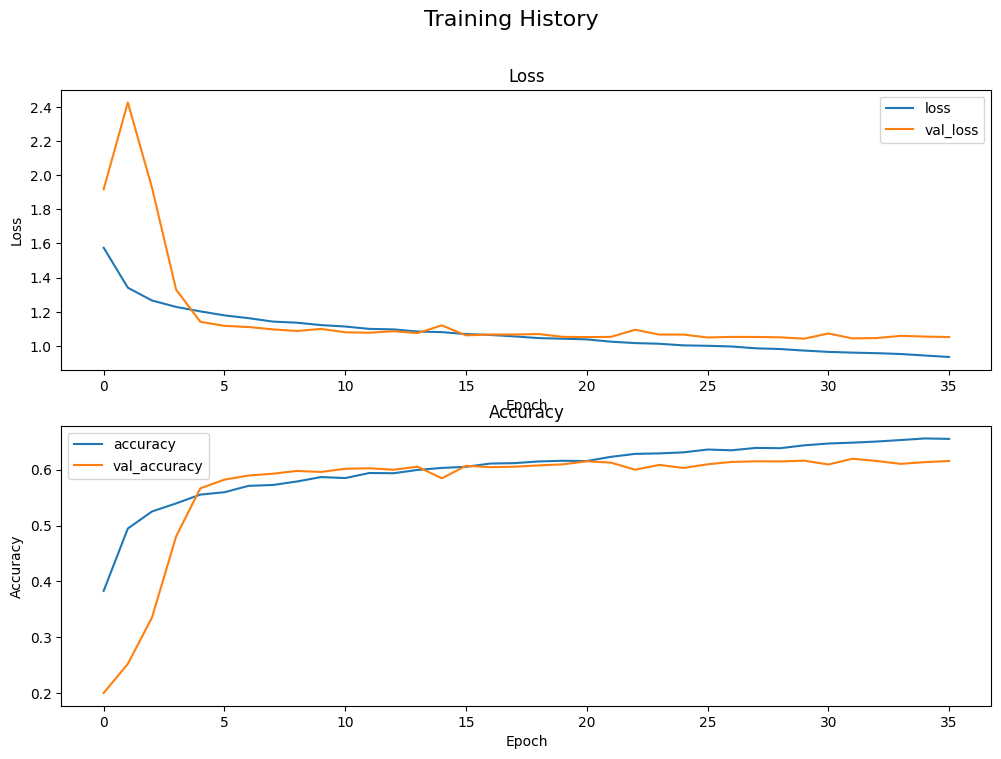

In [18]:
plot_training_history(history)

In [19]:
model_1_name = 'CNN_MFCC'
model_1_file_name = 'v6c_mfcc_scaled_segmentresampled53_128_22500_1000_cnn_2d_128_batch_200_epoch_lr_0001.keras'
#model_1.save(SAVED_MODEL_PATH+model_1_file_name)

In [20]:
model_1 = ModelEvaluation(model_1_name,model_1_file_name,X_test, y_test, label_encoder)

171/171 [==============================] - 5s 26ms/step


Evaluating Model:  CNN_MFCC
171/171 - 5s - loss: 1.0422 - accuracy: 0.6196 - 5s/epoch - 28ms/step

Test Accuracy: 61.96%
Test Loss: 1.0422

Classification Report:
              precision    recall  f1-score   support

   classical       0.75      0.86      0.80      1315
     country       0.44      0.15      0.23       295
  electronic       0.55      0.53      0.54      1116
      hiphop       0.68      0.67      0.68       797
        jazz       0.42      0.25      0.32       670
        rock       0.57      0.72      0.64      1264

    accuracy                           0.62      5457
   macro avg       0.57      0.53      0.53      5457
weighted avg       0.60      0.62      0.60      5457



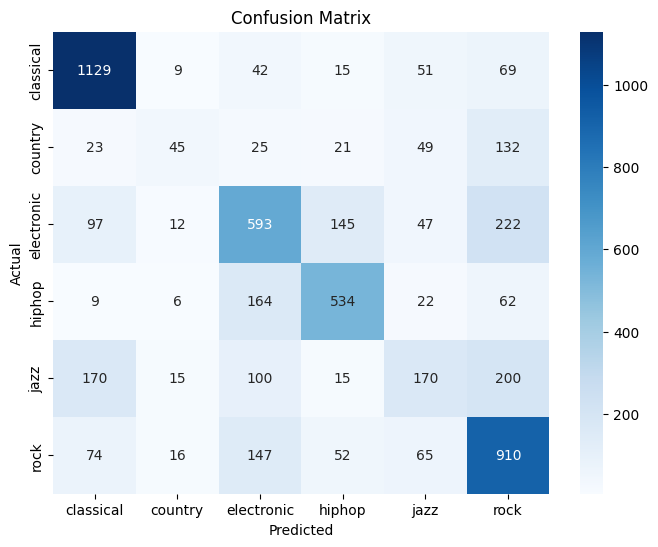

In [21]:
model_1.evaluate()

## Scenario 2: Using Log MelSepctrogram 128X500 feature vector

This section utilizes Log Mel Spectrograms for training 

In [2]:
X_train, X_test, y_train, y_test,label_encoder =get_feature_vector_data(vector_type = 'log_mel',
                                                        version_string = '006',
                                                        vector_length = 500, 
                                                        #vector_length = 1000, 
                                                        apply_normalization = True,
                                                        apply_resampling=False
                                                        )

Loading log mel vectors
features shape distribution
1099    20865
1         221
293         2
173         2
862         2
392         1
467         1
201         1
946         1
622         1
Name: count, dtype: int64
total records:  21164
normalized length:  20865
Row Count after label based filter:  21164
Final Row count after label and feature filter:  20865
Unique label count:  6
label data count  20865
Truncate features to consistent length and reshape
Generate train_test_split for test size  0.2
applying normalization


In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(TensorShape([16692, 500, 128, 1]),
 TensorShape([4173, 500, 128, 1]),
 (16692, 6),
 (4173, 6))

In [4]:
#for checking the class balance
np.unique(np.argmax(y_train,axis=1),return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([1051,  235, 5260, 2891,  535, 6720]))

In [5]:
selected_hp = {'learning_rate':  0.0001}
#selected_hp = {'learning_rate':  0.001}

type(selected_hp)
model_2 = get_2d_cnn(selected_hp)

In [6]:
history = model_2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    
    #batch_size=32,
    #batch_size=64,
    batch_size = 128,
    #epochs=200,
    epochs = 200,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),

    ]
)

Epoch 1/200
131/131 [==============================] - 613s 5s/step - loss: 1.0083 - accuracy: 0.6370 - val_loss: 1.5869 - val_accuracy: 0.5454
Epoch 2/200
131/131 [==============================] - 583s 4s/step - loss: 0.7594 - accuracy: 0.7283 - val_loss: 2.4106 - val_accuracy: 0.3757
Epoch 3/200
131/131 [==============================] - 606s 5s/step - loss: 0.6444 - accuracy: 0.7666 - val_loss: 1.5507 - val_accuracy: 0.5572
Epoch 4/200
131/131 [==============================] - 517s 4s/step - loss: 0.5499 - accuracy: 0.7997 - val_loss: 0.8505 - val_accuracy: 0.7043
Epoch 5/200
131/131 [==============================] - 515s 4s/step - loss: 0.4595 - accuracy: 0.8333 - val_loss: 0.7202 - val_accuracy: 0.7541
Epoch 6/200
131/131 [==============================] - 529s 4s/step - loss: 0.3828 - accuracy: 0.8605 - val_loss: 0.6765 - val_accuracy: 0.7644
Epoch 7/200
131/131 [==============================] - 519s 4s/step - loss: 0.3177 - accuracy: 0.8880 - val_loss: 0.6923 - val_accuracy:

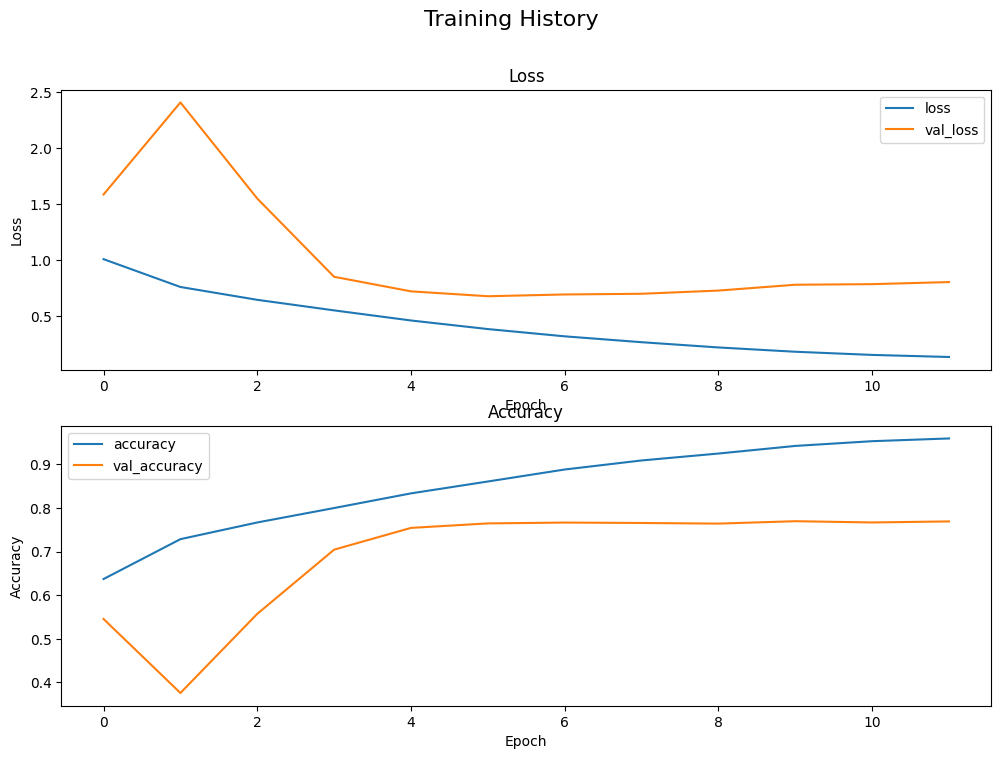

In [7]:
plot_training_history(history)

In [ ]:
model_2_name = 'CNN_LogMel'
model_2_file_name='v6c_log_scaled_128_22500_500_cnn_2d_128_batch_200_epoch_lr_0001.keras'


#model_2.save(SAVED_MODEL_PATH+model_2_file_name)

131/131 [==============================] - 31s 234ms/step
Evaluating Model:  CNN_LogMel
131/131 - 36s - loss: 0.6765 - accuracy: 0.7644 - 36s/epoch - 275ms/step

Test Accuracy: 76.44%
Test Loss: 0.6765

Classification Report:
              precision    recall  f1-score   support

   classical       0.74      0.79      0.76       263
     country       0.00      0.00      0.00        59
  electronic       0.74      0.73      0.73      1314
      hiphop       0.75      0.72      0.74       723
        jazz       0.49      0.33      0.39       134
        rock       0.80      0.87      0.84      1680

    accuracy                           0.76      4173
   macro avg       0.59      0.57      0.58      4173
weighted avg       0.75      0.76      0.76      4173



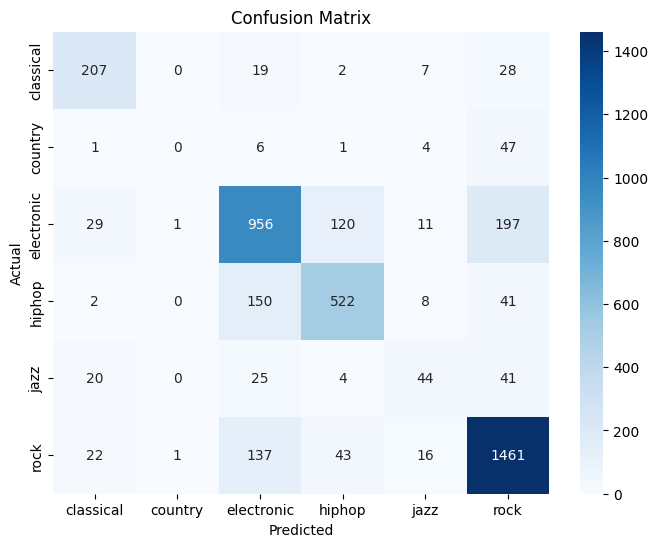

In [9]:
model_2 = ModelEvaluation(model_2_name,model_2_file_name,X_test, y_test, label_encoder)
model_2.evaluate()
